In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import palettable.colorbrewer.sequential as pcs
import palettable.colorbrewer.diverging as pcd

from statsmodels.stats.outliers_influence import variance_inflation_factor

import libpysal

from esda.moran import Moran,Moran_Local

from spreg import OLS, ML_Lag

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

from splot.esda import lisa_cluster

from patsy import dmatrices

In [2]:
# read in data
pre_df=pd.read_csv('data/lsoa_data.csv')
# lsoa geometry
boundary=gpd.read_file('data/LSOA_boundary/LDN-LSOAs.shp')

# merge two dataframes
gdf=gpd.GeoDataFrame(pre_df).merge(boundary,left_on='Codes',right_on='lsoa11cd')
# drop excessive columns
gdf=gdf.drop(['lsoa11cd','lsoa11nm','lsoa11nmw','objectid','st_areasha','st_lengths'],axis=1)

In [3]:
# explore the structure of the data
gdf['kMedianHP']=gdf['MedianHP']/1000
gdf['kMedianHP'].describe()

count    4835.000000
mean      329.465551
std       215.083933
min         0.000000
25%       217.000000
50%       267.500000
75%       369.000000
max      3377.000000
Name: kMedianHP, dtype: float64

In [4]:
# remove lsoas wth no house price data
gdf=gdf[gdf['kMedianHP']>0]

# check correlation between dependent and independent variables
gdf.corr(method='kendall')['MedianHP']

MedianHP             1.000000
MedianIncome         0.541982
Pct_nonwhite        -0.260607
Pct_CHDC            -0.022876
Pct_workingage       0.154324
UnRate              -0.417957
c_per_hhlds          0.067235
PTAL_average         0.121890
Pct_qual_above_l4    0.507439
kMedianHP            1.000000
Name: MedianHP, dtype: float64

In [5]:
# list all the independent variables
var_n=gdf.columns.tolist()[3:-2]

In [6]:
var_n.remove('c_per_hhlds')
var_n.remove('Pct_CHDC')

gdf.drop(['Pct_CHDC','c_per_hhlds'],inplace=True,axis=1)

In [7]:
def vif(df,dep_var,list):
    form=''
    for i in list:
        form+=i
        if i != list[-1]:
            form+='+'
    y,X=dmatrices(dep_var+ ' ~ ' + form, data=df,return_type='dataframe')

    vif=pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable']=X.columns

    return vif

In [8]:
# check VIF
vif(gdf,'kMedianHP',var_n)

,VIF,variable
0,292.151736,Intercept
1,4.948626,MedianIncome
2,1.799630,Pct_nonwhite
3,2.365741,Pct_workingage
4,2.732144,UnRate
5,1.786629,PTAL_average
6,5.169737,Pct_qual_above_l4


In [9]:
# Check correlation with MedianIncome
gdf.corr(method='kendall')['MedianIncome']

MedianHP             0.541982
MedianIncome         1.000000
Pct_nonwhite        -0.438889
Pct_workingage       0.118584
UnRate              -0.647524
PTAL_average         0.003409
Pct_qual_above_l4    0.547378
kMedianHP            0.541982
Name: MedianIncome, dtype: float64

In [10]:
gdf.corr(method='kendall')['Pct_qual_above_l4']

MedianHP             0.507439
MedianIncome         0.547378
Pct_nonwhite        -0.198566
Pct_workingage       0.413545
UnRate              -0.386378
PTAL_average         0.282159
Pct_qual_above_l4    1.000000
kMedianHP            0.507439
Name: Pct_qual_above_l4, dtype: float64

In [11]:
var_n.remove('Pct_qual_above_l4')

gdf.drop('Pct_qual_above_l4',inplace=True,axis=1)

In [12]:
# recheck VIF
vif(gdf,'kMedianHP',var_n)

,VIF,variable
0,212.401801,Intercept
1,2.407078,MedianIncome
2,1.774506,Pct_nonwhite
3,1.684418,Pct_workingage
4,2.724471,UnRate
5,1.666144,PTAL_average


In [13]:
# build simple OLS model
m_multi=OLS(gdf[['kMedianHP']].values,
            gdf[var_n].values,
            name_x=var_n,
            name_y='kMedianHP')

print(m_multi.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :    330.3538                Number of Variables   :           6
S.D. dependent var  :    214.6913                Degrees of Freedom    :        4816
R-squared           :      0.5744
Adjusted R-squared  :      0.5739
Sum squared residual:94575333.521                F-statistic           :   1299.9044
Sigma-square        :   19637.735                Prob(F-statistic)     :           0
S.E. of regression  :     140.135                Log likelihood        :  -30672.357
Sigma-square ML     :   19613.300                Akaike info criterion :   61356.714
S.E of regression ML:    140.0475                Schwarz criterion     :   61395.599

-----------------------------------------------------------------------------

In [14]:
# spatial weights matrix
weights=libpysal.weights.KNN.from_dataframe(gdf,k=6)
weights.transform='r'

In [ ]:
# check the normality of the residuals
plt.plot(m_multi.predy,
         m_multi.u,
         'oC0',
         markeredgecolor='white')
plt.axhline(linestyle='dashed',color='red')
plt.ylabel('Residuals')
plt.xlabel('Predicted y')
plt.show()

In [15]:
# spatial autocorrelation of the OLS residuals
gdf['multi_res']=m_multi.u
multi_res_moran=Moran(m_multi.u,weights)
print(multi_res_moran.I)
print(multi_res_moran.p_sim)

0.40125743976040046
0.001


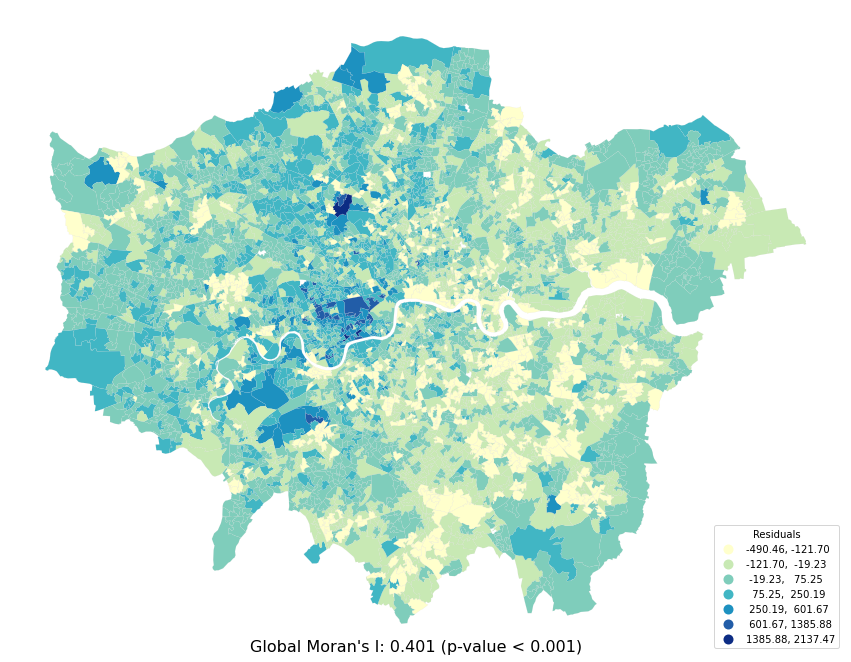

In [16]:
fig,ax=plt.subplots(1,figsize=(15,12))

gdf.plot(column='multi_res',scheme='FisherJenks',k=7,ax=ax,
         cmap=pcs.YlGnBu_7.mpl_colormap,edgecolor='lightgrey',linewidth=0.1,
         legend=True,legend_kwds={'loc':'lower right','title':'Residuals'})

plt.figtext(x=0.35,y=0.13,
            s="Global Moran's I: "+str(round(multi_res_moran.I,3))+" (p-value < "+str(multi_res_moran.p_sim)+")",fontsize=16)
ax.set_axis_off()

#plt.savefig('graph/map_res.png',dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

In [17]:
# build spatial lag model
m_Lag=ML_Lag(gdf[['kMedianHP']].values,
                   gdf[var_n].values,
                   weights,
                   name_x=var_n,
                   name_y='kMedianHP')
print(m_Lag.summary)

C:\Users\Yulun\anaconda3\envs\sds2021\lib\site-packages\scipy\optimize\_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :    330.3538                Number of Variables   :           7
S.D. dependent var  :    214.6913                Degrees of Freedom    :        4815
Pseudo R-squared    :      0.7120
Spatial Pseudo R-squared:  0.5689
Sigma-square ML     :   13298.048                Log likelihood        :  -29870.976
S.E of regression   :     115.317                Akaike info criterion :   59755.953
                                                 Schwarz criterion     :   59801.319

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [18]:
#Prepare dataset inputs
g_y = gdf['kMedianHP'].values.reshape((-1,1))
g_X = gdf[var_n].values
g_coords=[]
for i in gdf['geometry'].centroid.tolist():
    g_coords.append((i.x,i.y))

In [19]:
bw=Sel_BW(g_coords,g_y,g_X,fixed=False,kernel='gaussian',spherical=False)
bw.search()

53.0

In [20]:
# build GWR model
m_gwr=GWR(g_coords,g_y,g_X,bw.bw[0],kernel='gaussian')
m_gwr_fit=m_gwr.fit()
m_gwr_fit.summary()

Model type                                                         Gaussian
Number of observations:                                                4822
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       94575333.521
Log-likelihood:                                                  -30672.357
AIC:                                                              61356.714
AICc:                                                             61358.737
BIC:                                                           94534489.295
R2:                                                                   0.574
Adj. R2:                                                              0.574

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [21]:
# filter all the statistically insignificant (at 0.05 level) results
f_est=m_gwr_fit.filter_tvals(alpha=.05)

In [22]:
var_n

['MedianIncome', 'Pct_nonwhite', 'Pct_workingage', 'UnRate', 'PTAL_average']

In [23]:
# merge the model result with the original dataframe
data_params=pd.DataFrame(f_est)
data_localR2=pd.DataFrame(m_gwr_fit.localR2)

tem_df=pd.DataFrame(gdf[['Codes','Names','kMedianHP','geometry']])
result_df=tem_df.assign(intercept=data_params[0],
                        MedianIncome=data_params[1],
                        Pct_nonwhite=data_params[2],
                        Pct_workingage=data_params[3],
                        UnRate=data_params[4],
                        PTAL_average=data_params[5],
                        localR2=data_localR2[0])

result_gdf=gpd.GeoDataFrame(result_df,geometry='geometry')

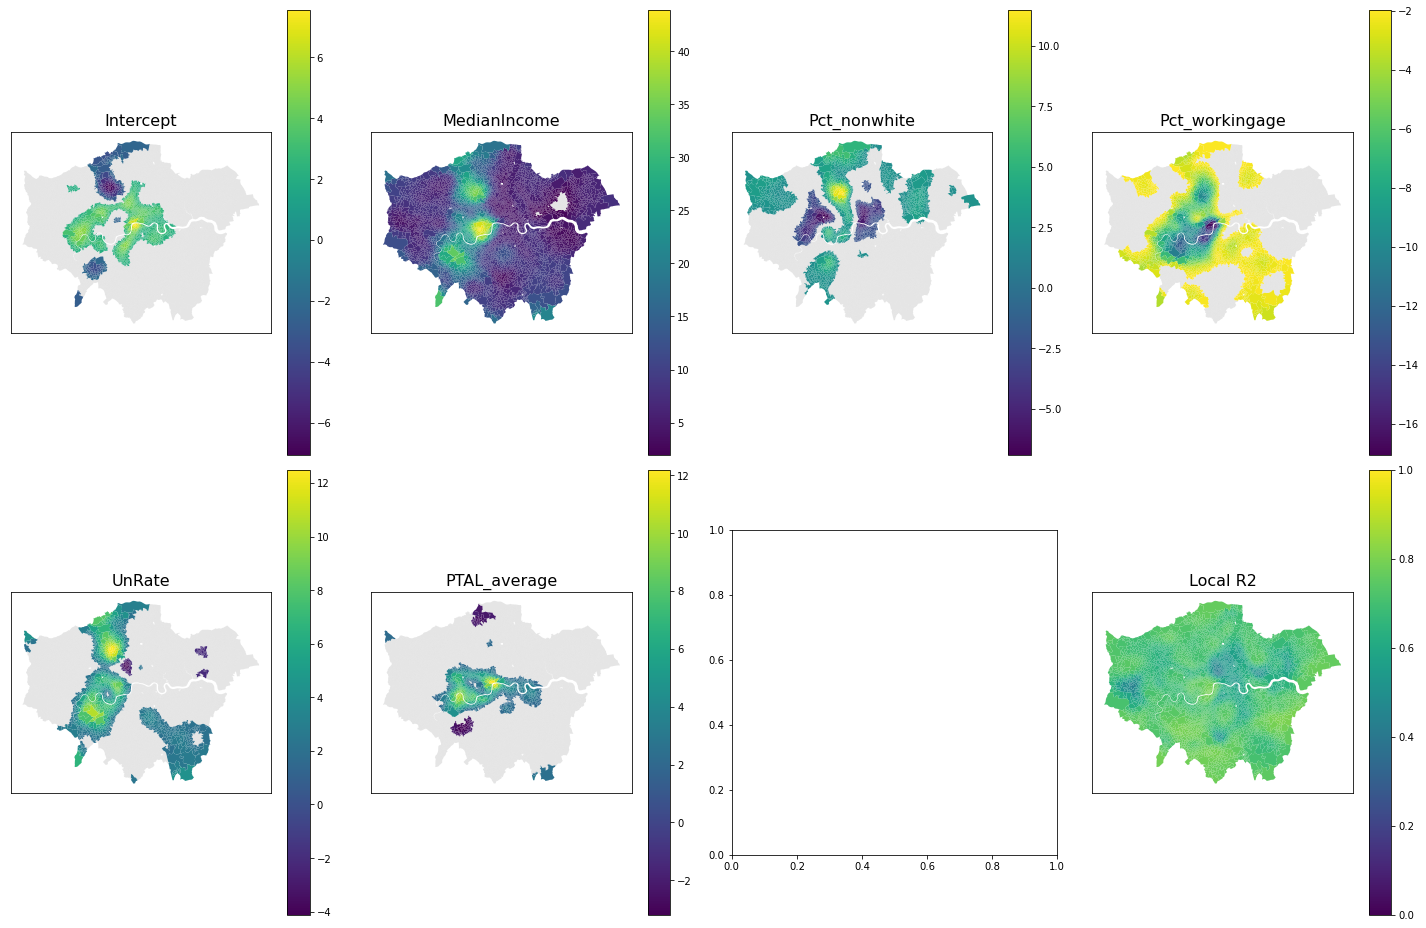

In [24]:
fig,ax=plt.subplots(2,4,figsize=(20,13), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

titles = ['Intercept']+var_n

for i,row in enumerate(f_est.T):
    temp = result_gdf.assign(toplot=f_est.T[i])
    temp.query('toplot==0').sort_values('toplot').plot(color='grey',ax=ax[i],alpha=.2)

    temp.query('toplot!=0').sort_values('toplot').plot('toplot',cmap='viridis',ax=ax[i],legend=True)
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

result_gdf.assign(r2=m_gwr_fit.localR2).sort_values('r2').plot('r2',ax=ax[-1],legend=True,
                                                               vmin=0,vmax=1,cmap='viridis')
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
fig.tight_layout()
    
plt.show()

In [25]:
# calculate residuals
result_gdf['predy']=m_gwr_fit.predy
result_gdf['resid']=result_gdf['kMedianHP']-result_gdf['predy']
result_gdf['pct_resid']=result_gdf['resid']/result_gdf['kMedianHP']

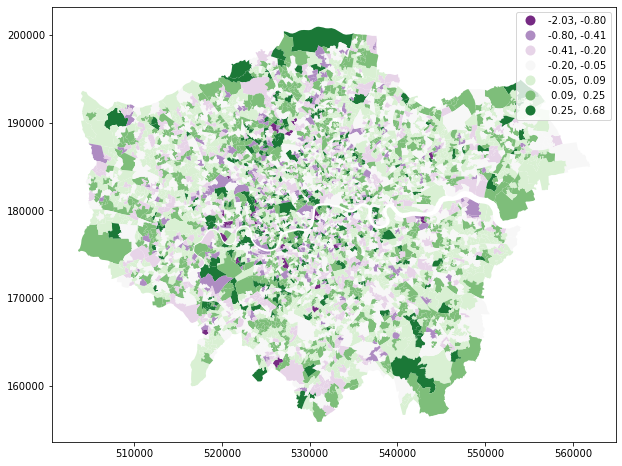

In [26]:
# plot the residuals spatial distribution
fig,ax=plt.subplots(1,figsize=(12,8))
result_gdf.plot(column='pct_resid',cmap=pcd.PRGn_7.mpl_colormap,scheme='fisherjenks',k=7,legend=True,ax=ax)
plt.show()

In [27]:
# global moran's I of the GWR residuals
gwr_res_moran=Moran(result_gdf['pct_resid'].values,weights)
print(gwr_res_moran.I)
print(gwr_res_moran.p_sim)

0.06673979876567493
0.001


In [28]:
# local moran's I
moran_loc_res=Moran_Local(result_gdf['pct_resid'].values,weights,permutations=999)

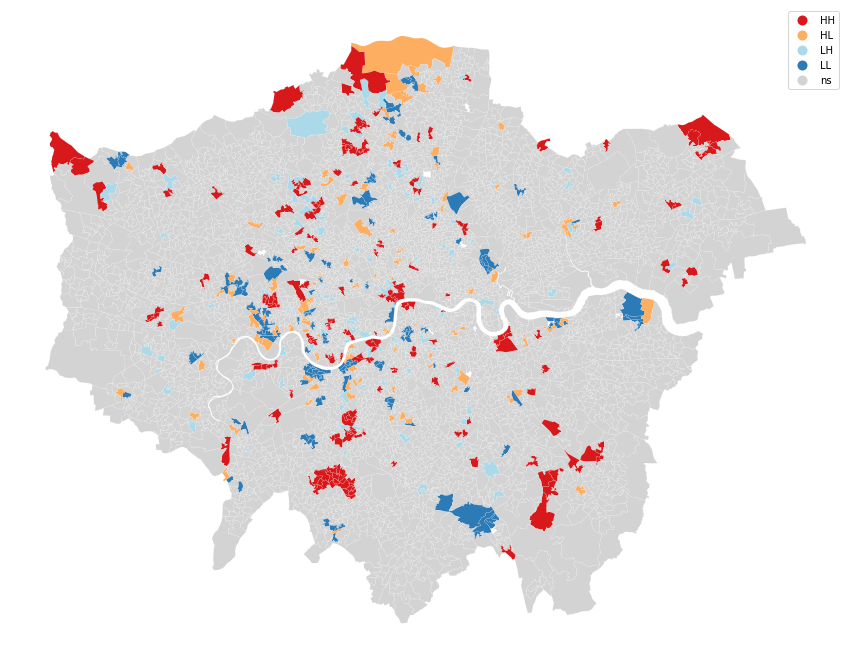

In [29]:
# lisa cluster map
fig,ax=plt.subplots(1,figsize=(15,12))
lisa_cluster(moran_loc_res,gdf,p=0.05,ax=ax)
plt.show()